In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(50,25)}
)

customer = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                                              'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                              'order_estimated_delivery_date'])


# Определения
- покупка - это order_purchase_timestamp is not null 
- заказ - это статус delivered & order_approved_at is not null 
- свойства заказа (месяц, день недели) order_purchase_timestamp
- причины отмены заказа- это статус заказа

In [2]:
orders_clean = (
    orders
    .query("order_purchase_timestamp.notnull()")
)



In [3]:
orders_wth_user = (
    orders_clean
    .merge(
        customer[['customer_id', 'customer_unique_id']], 
        on = 'customer_id', 
        how = 'left'
    )
    
)

## Вопрос 1

In [9]:
(
    orders_wth_user
    .groupby('customer_unique_id', as_index=False)
    .agg(orders = ('order_id', 'nunique'))
    .query('orders == 1')
    .customer_unique_id
    .nunique()
)


93099

## Вопрос 2

In [10]:

(
    orders
    .assign(month = orders.order_estimated_delivery_date.values.astype('datetime64[M]'))
    .groupby(['order_status', 'month'], as_index=False)
    .agg(orders = ('order_id', 'nunique'))
    .assign(unique_months = lambda x: x.month.nunique())
    .groupby('order_status', as_index=False)
    .agg(
        orders = ('orders', 'sum'),
        months = ('unique_months', 'mean')
    )
    .assign(avg_order_per_month = lambda x: x.orders/x.months)
    .sort_values(by='avg_order_per_month', ascending=False)
    .query("order_status != 'delivered'")
    [['order_status', 'avg_order_per_month']]
)


,order_status,avg_order_per_month
6,shipped,41.000000
1,canceled,23.148148
7,unavailable,22.555556
4,invoiced,11.629630
5,processing,11.148148
2,created,0.185185
0,approved,0.074074


## Вопрос 3

In [11]:
(
    order_items
    .merge(orders[['order_id', 'order_purchase_timestamp']], on = 'order_id', how = 'left')
    .assign(weekday = lambda x: x.order_purchase_timestamp.dt.day_name())
    .groupby(['product_id','weekday'], as_index=False)
    .agg(purchases = ('order_id','count'))
    .sort_values(by=['product_id','purchases'], ascending=False)
    .groupby('product_id', as_index=False)
    .head(1)
)


,product_id,weekday,purchases
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
61224,fff9553ac224cec9d15d49f5a263411f,Friday,1
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
61221,fff6177642830a9a94a0f2cba5e476d1,Saturday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


## Вопрос 4





In [26]:
(
    orders_wth_user
    .assign(
        month = lambda x: x.order_purchase_timestamp.dt.month,
        days_in_month = lambda x: x.order_purchase_timestamp.dt.daysinmonth 
    )
    .groupby(['customer_unique_id','month', 'days_in_month'], as_index=False)
    .agg(orders = ('order_id', 'nunique'))
    .assign(
        avg_weeks = lambda x: x.days_in_month / 7,
        avg_order_per_week = lambda x: x.orders / x.avg_weeks
    )
)



,customer_unique_id,month,days_in_month,orders,avg_weeks,avg_order_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,5,31,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5,31,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,3,31,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,10,31,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,11,30,1,4.285714,0.233333
...,...,...,...,...,...,...
97996,fffcf5a5ff07b0908bd4e2dbc735a684,6,30,1,4.285714,0.233333
97997,fffea47cd6d3cc0a88bd621562a9d061,12,31,1,4.428571,0.225806
97998,ffff371b4d645b6ecea244b27531430a,2,28,1,4.000000,0.250000
97999,ffff5962728ec6157033ef9805bacc48,5,31,1,4.428571,0.225806


## Вопрос 5

In [4]:
cohort = (
    orders_wth_user
    .assign(
        cohort_month = lambda x: x.groupby('customer_unique_id').order_purchase_timestamp.transform('min').values.astype('datetime64[M]'),
        month_full = lambda x: x.order_purchase_timestamp.values.astype('datetime64[M]'),
        cohort_index = lambda x: (x.month_full.dt.year - x.cohort_month.dt.year)*12 + (x.month_full.dt.month - x.cohort_month.dt.month)
    )
    .groupby(['cohort_month', 'cohort_index'], as_index=False)
    .agg(users = ('customer_unique_id', 'nunique'))
    .query('cohort_month >= "2017-01-01" and cohort_month <= "2017-12-01"')
    .pivot(index='cohort_month', columns='cohort_index', values='users')
)

retention = (
    cohort
    .divide(cohort[0], axis=0)
    .round(4)
)
retention.index = retention.index.strftime('%Y-%m')
retention[[3]].idxmax()



cohort_index
3    2017-06
dtype: object

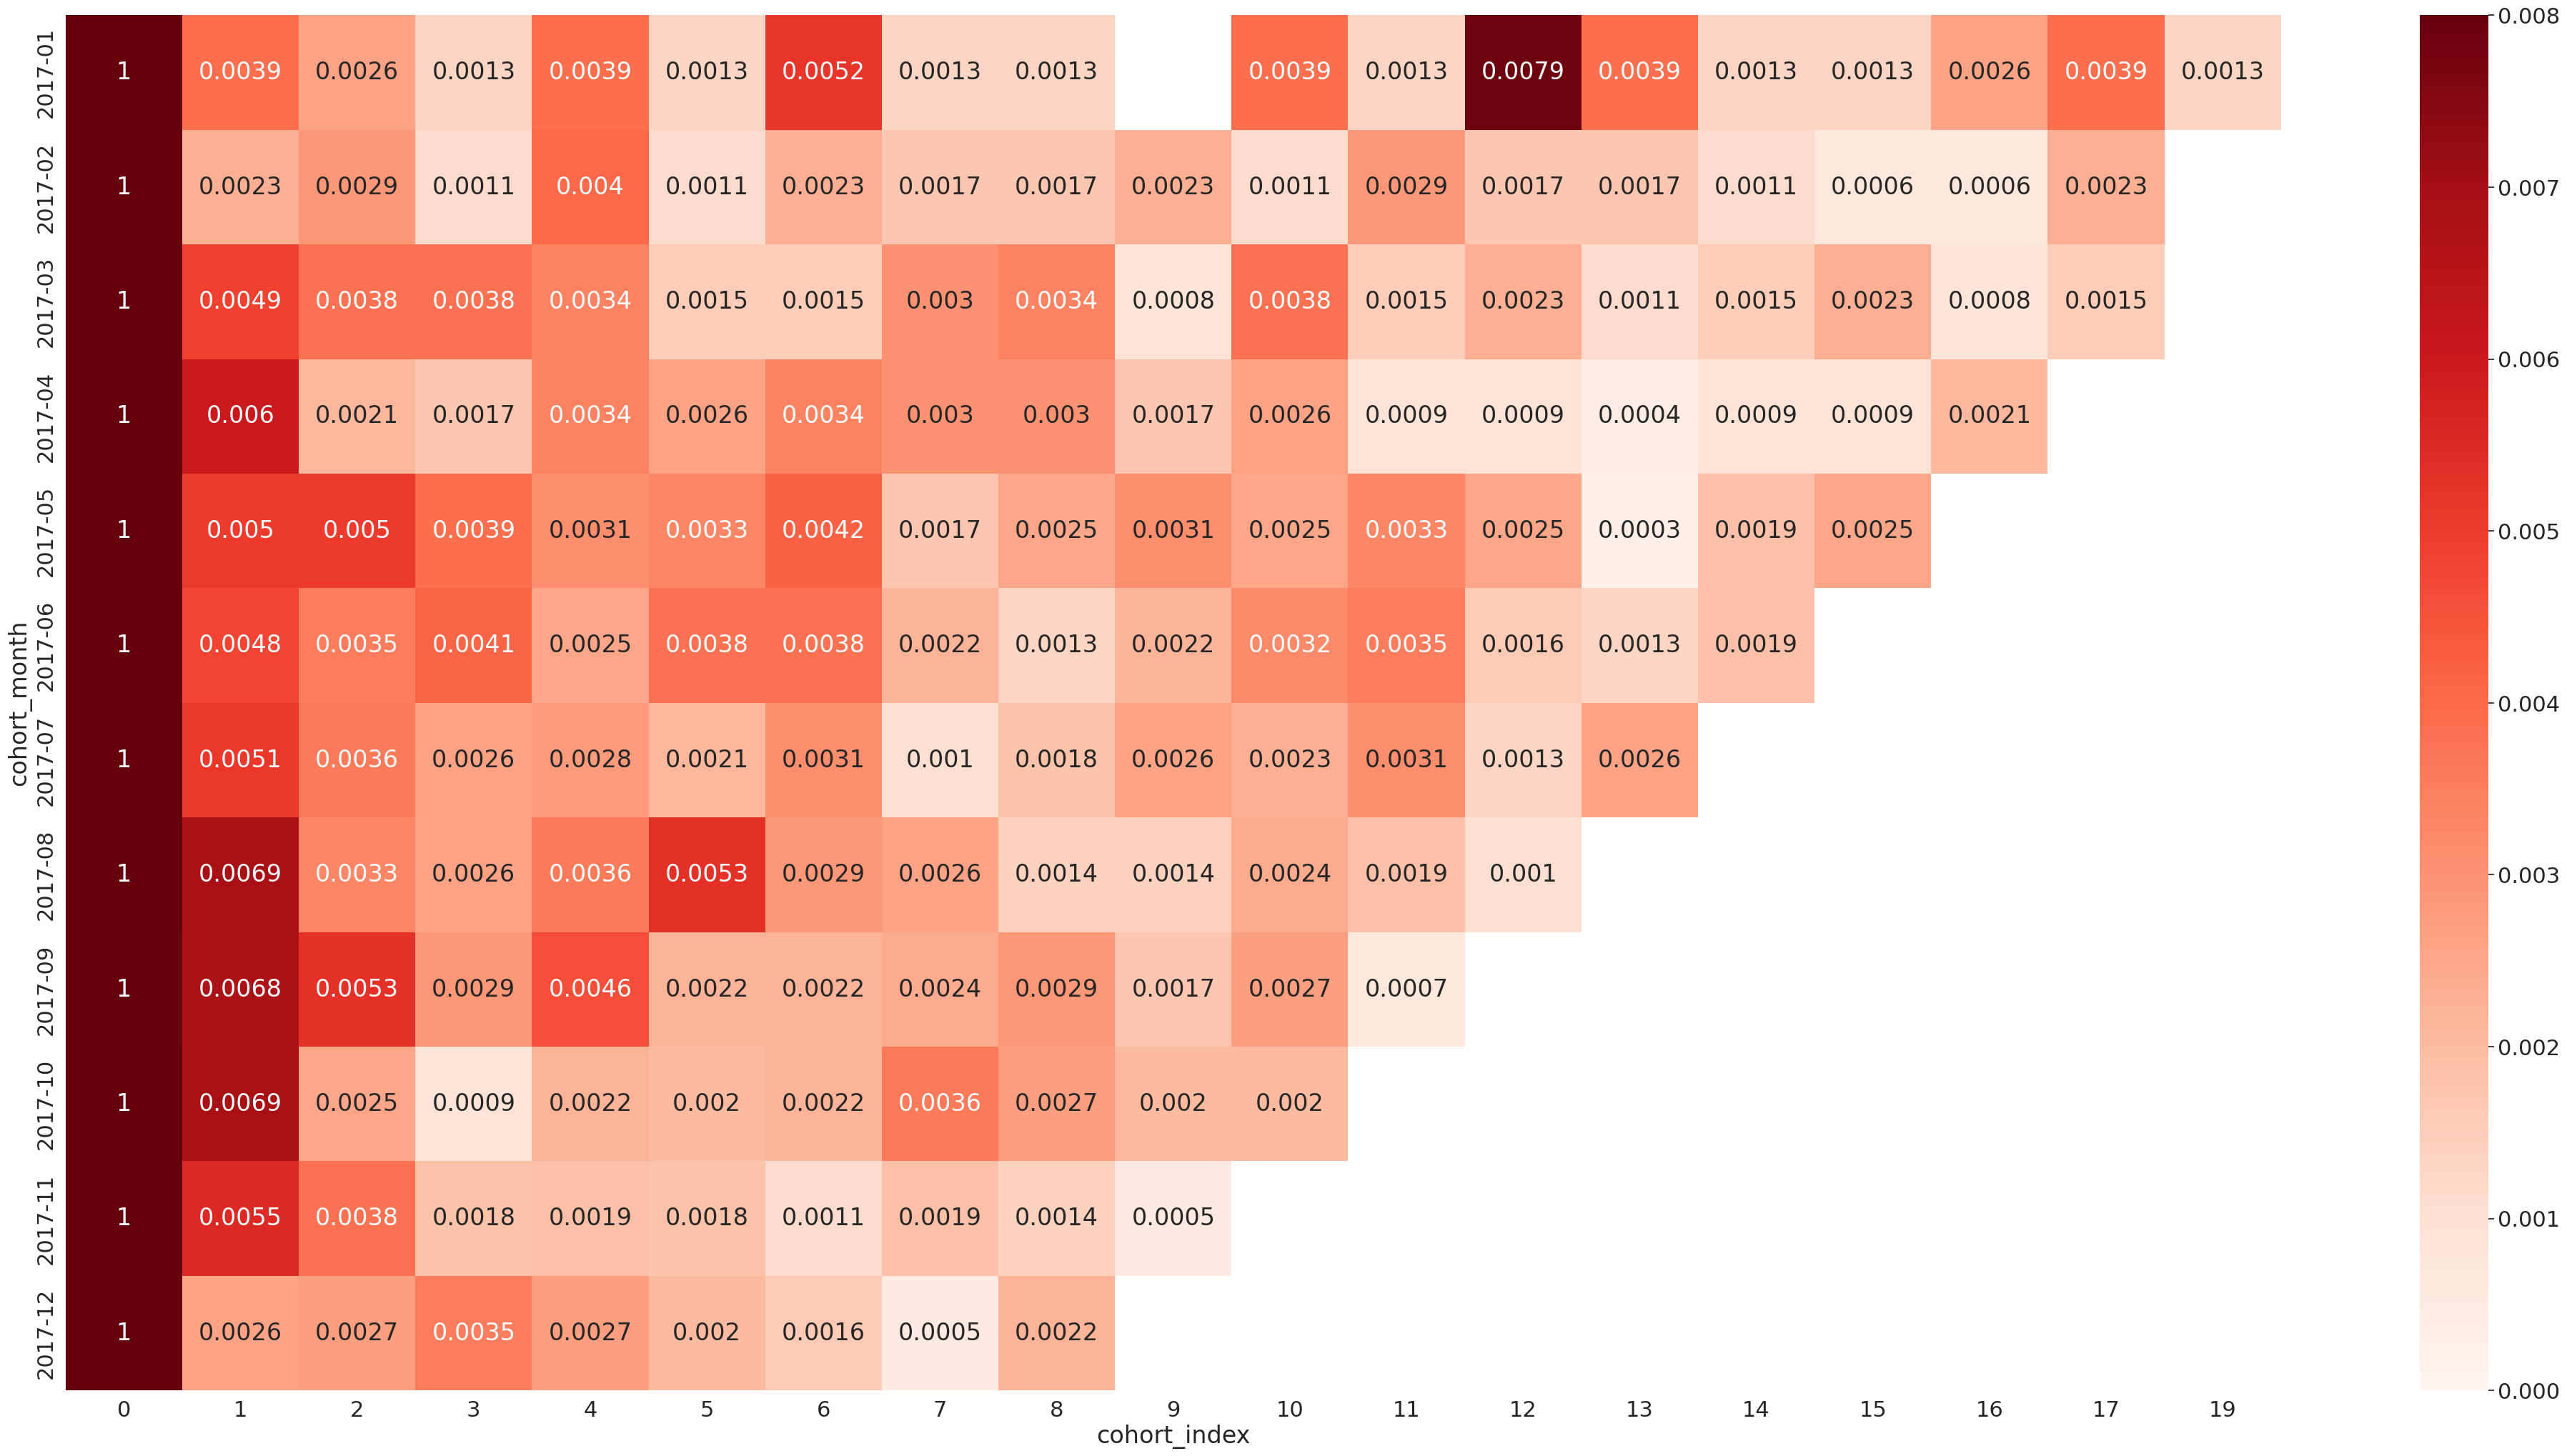

In [5]:
# Initialize the figure
plt.figure(figsize=(50, 25))
# Creating the heatmap
sns.heatmap(retention, annot = True,vmin = 0.0, vmax = 0.008,cmap="Reds")
plt.show()

## Вопрос 6

In [29]:
order_from_items = (
    order_items
    .merge(orders[['order_id', 'customer_id','order_purchase_timestamp']], on = 'order_id', how = 'left')
    .merge(customer[['customer_id', 'customer_unique_id']], on = 'customer_id', how = 'left')
    .groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False)
    .agg(price = ('price', 'sum'))
)

NOW = order_from_items['order_purchase_timestamp'].max() + timedelta(days=1)



In [59]:
rfm = (
    order_from_items
    .assign(order_purchase_timestamp = lambda x: (NOW - x.order_purchase_timestamp).dt.days)
    .groupby('customer_unique_id', as_index=False)
    .agg(
        Recency = ('order_purchase_timestamp', 'min'),
        Frequency = ('order_id', 'count'),
        Monetary = ('price', 'sum')
    )
)



## Определение кластеров 

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


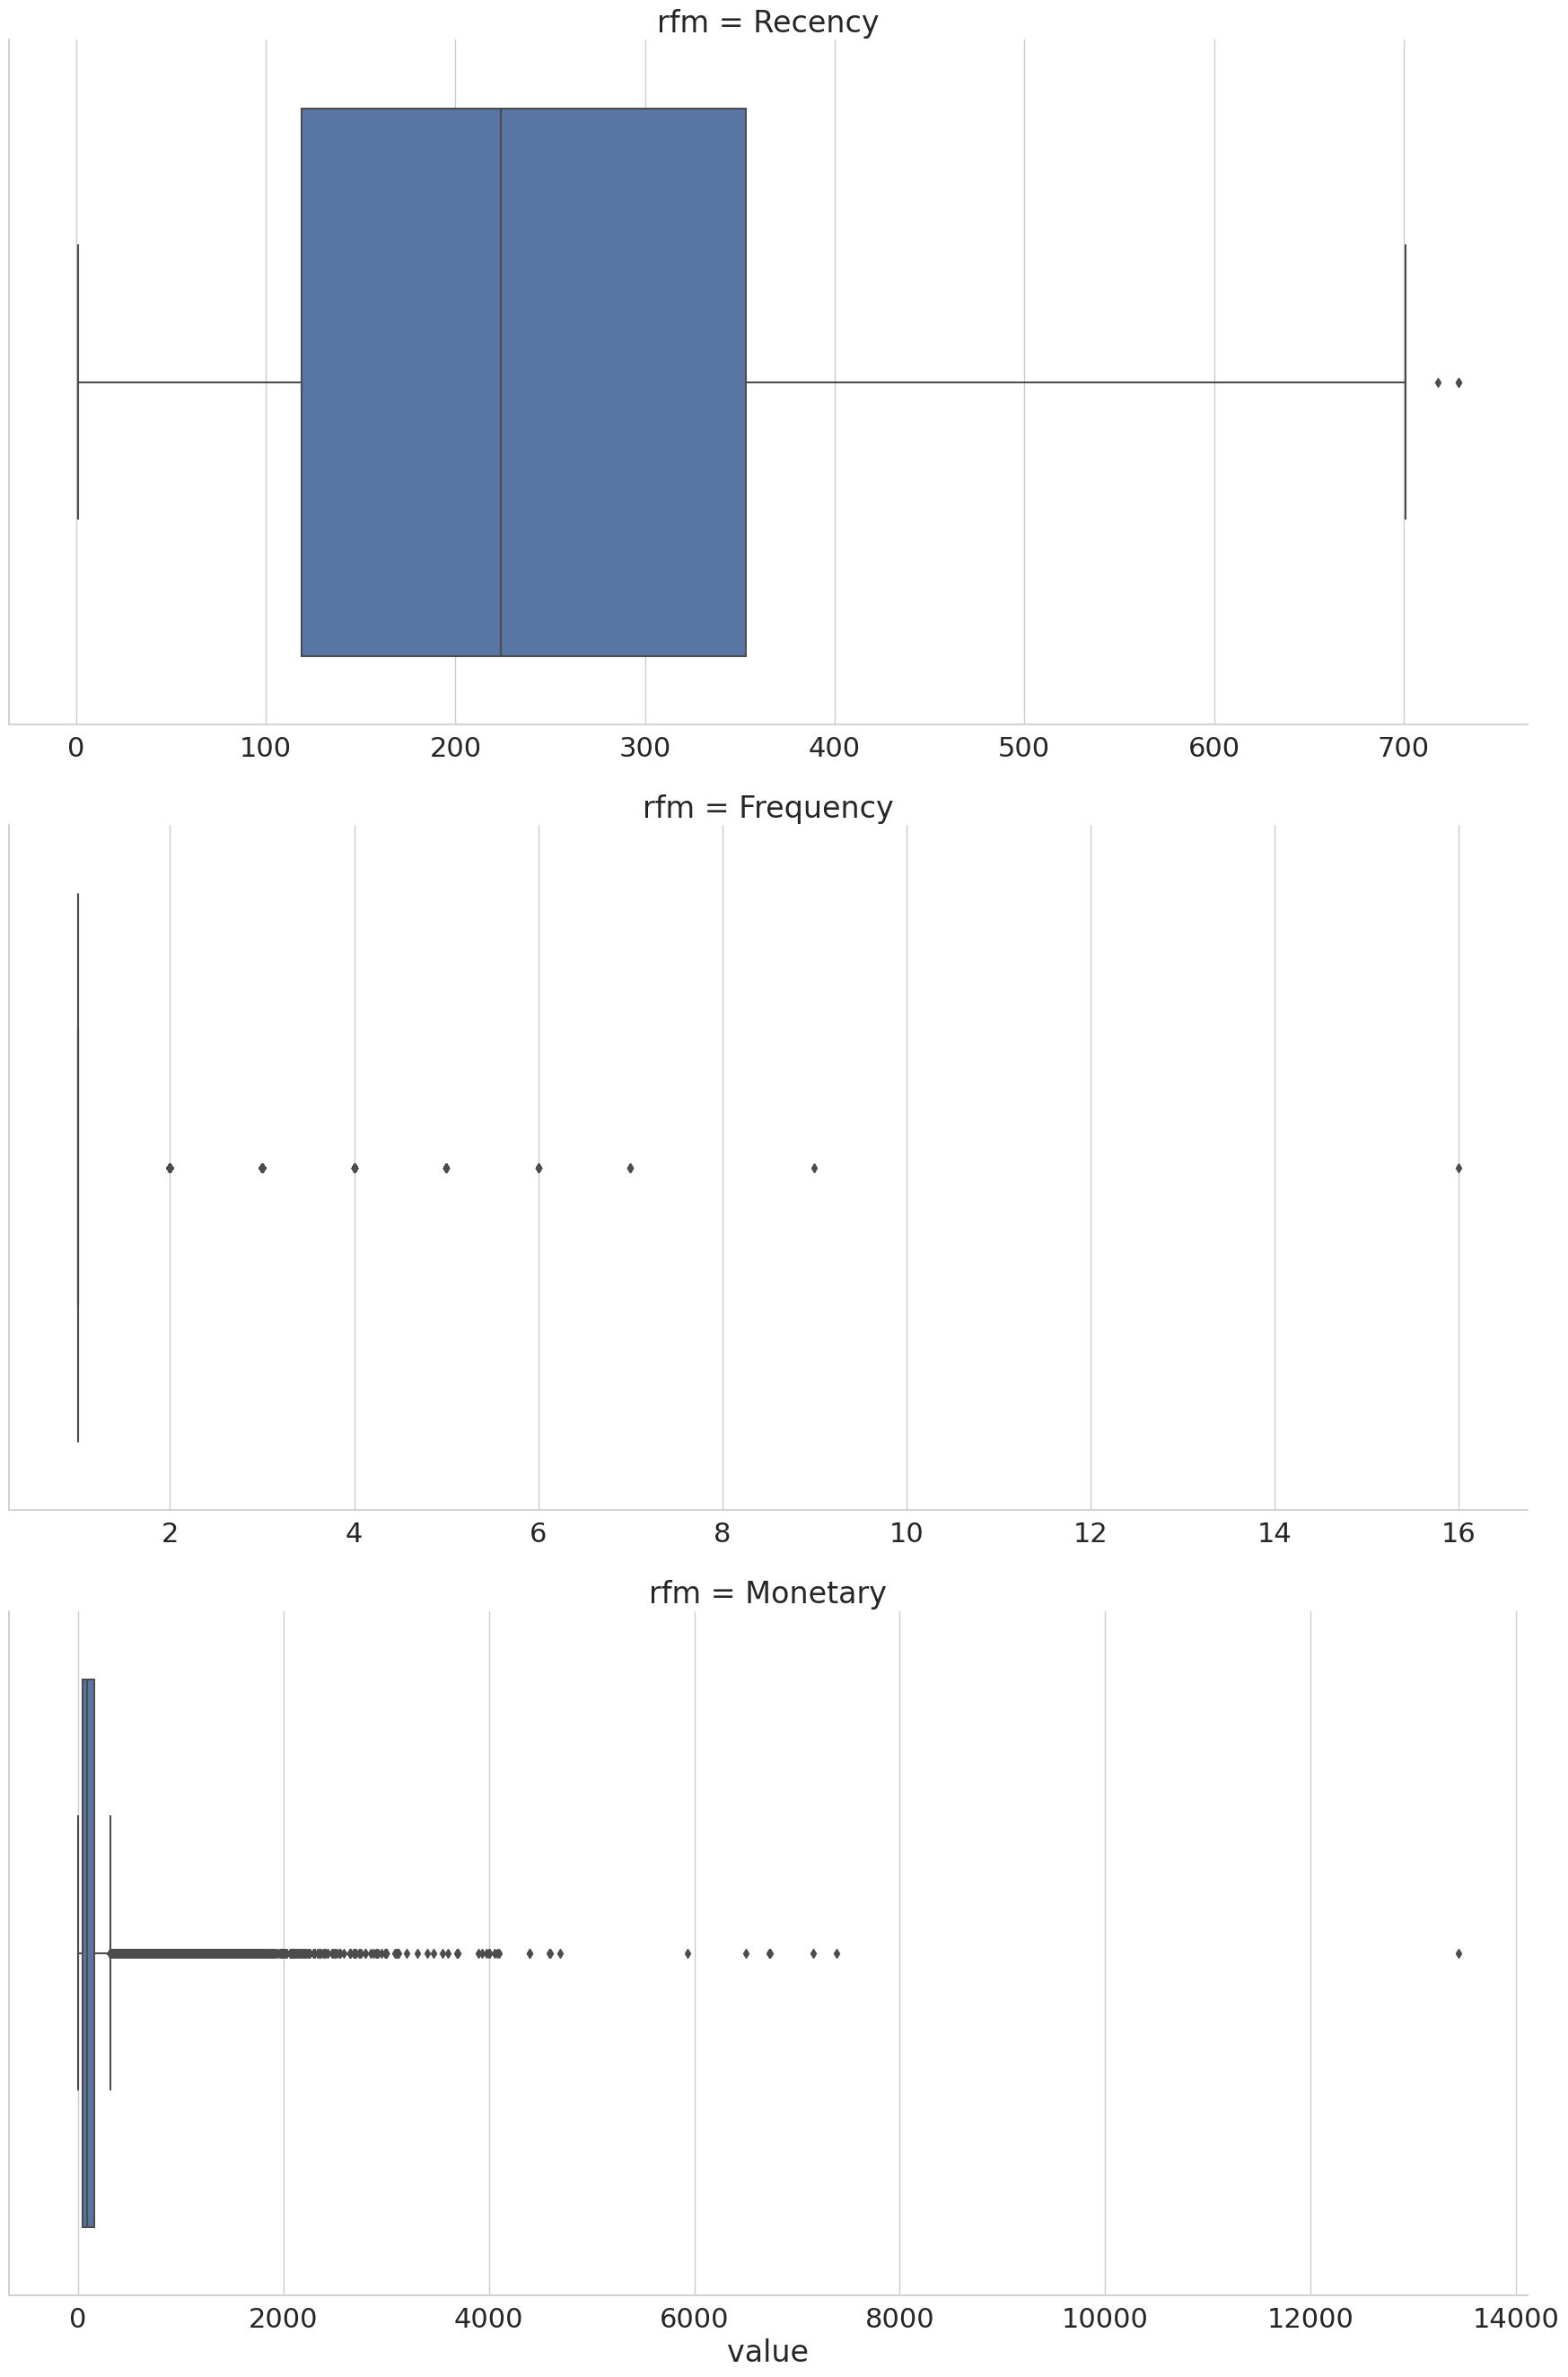

In [78]:
rfm_grid = sns.FacetGrid(
    data = rfm.melt(id_vars='customer_unique_id', var_name='rfm', value_name='value'), row='rfm', height=9, aspect=2, sharey=False, sharex=False
)

rfm_grid.map(sns.boxplot, 'value')

Исходя из графика выше:
  1. Recency - не имеет сильных искажений или выбросов  
  2. Frequency - большая часть пользователей совершают всего одну покупку  
  3. Monetary - сильно искаженно в право из-за сильных выбросов
    
На сонве этих выводов следует:
  1. Испоьзовать стандартное rfm деление из пяти квантелей  
  2. Создать две группы - один заказ и больше одного заказа  
  3. Исключить выборсы и потом использовать стандартное rfm деление из пяти квантелей  

In [93]:
def min_outlier(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3 - q1
    return (q3 + (3*IQR))

def r_score(x, quantiles):
    if x <= quintiles['Recency'][.25]:
        return 4
    elif x <= quintiles['Recency'][.5]:
        return 3
    elif x <= quintiles['Recency'][.75]:
        return 2
    else:
        return 1

def m_score(x, quantiles):
    if x <= quintiles['Monetary'][.25]:
        return 1
    elif x <= quintiles['Monetary'][.5]:
        return 2
    elif x <= quintiles['Monetary'][.75]:
        return 3
    else:
        return 4
    
def f_score(x):
    if x == 1:
        return 1
    else:
        return 2


In [92]:
monetary_thershold = min_outlier(rfm.Monetary)
rfm = rfm.query('Monetary < @monetary_thershold')

In [101]:
# create quantiles
quintiles = rfm[['Recency', 'Monetary']].quantile([.25, .5, .75]).to_dict()

# generate rfm score
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x, quintiles))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x, quintiles))
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)


In [187]:
clusters = (
    rfm
    .groupby(['R', 'F', 'M'], as_index=False)
    .agg(users=('customer_unique_id', 'nunique'))
)



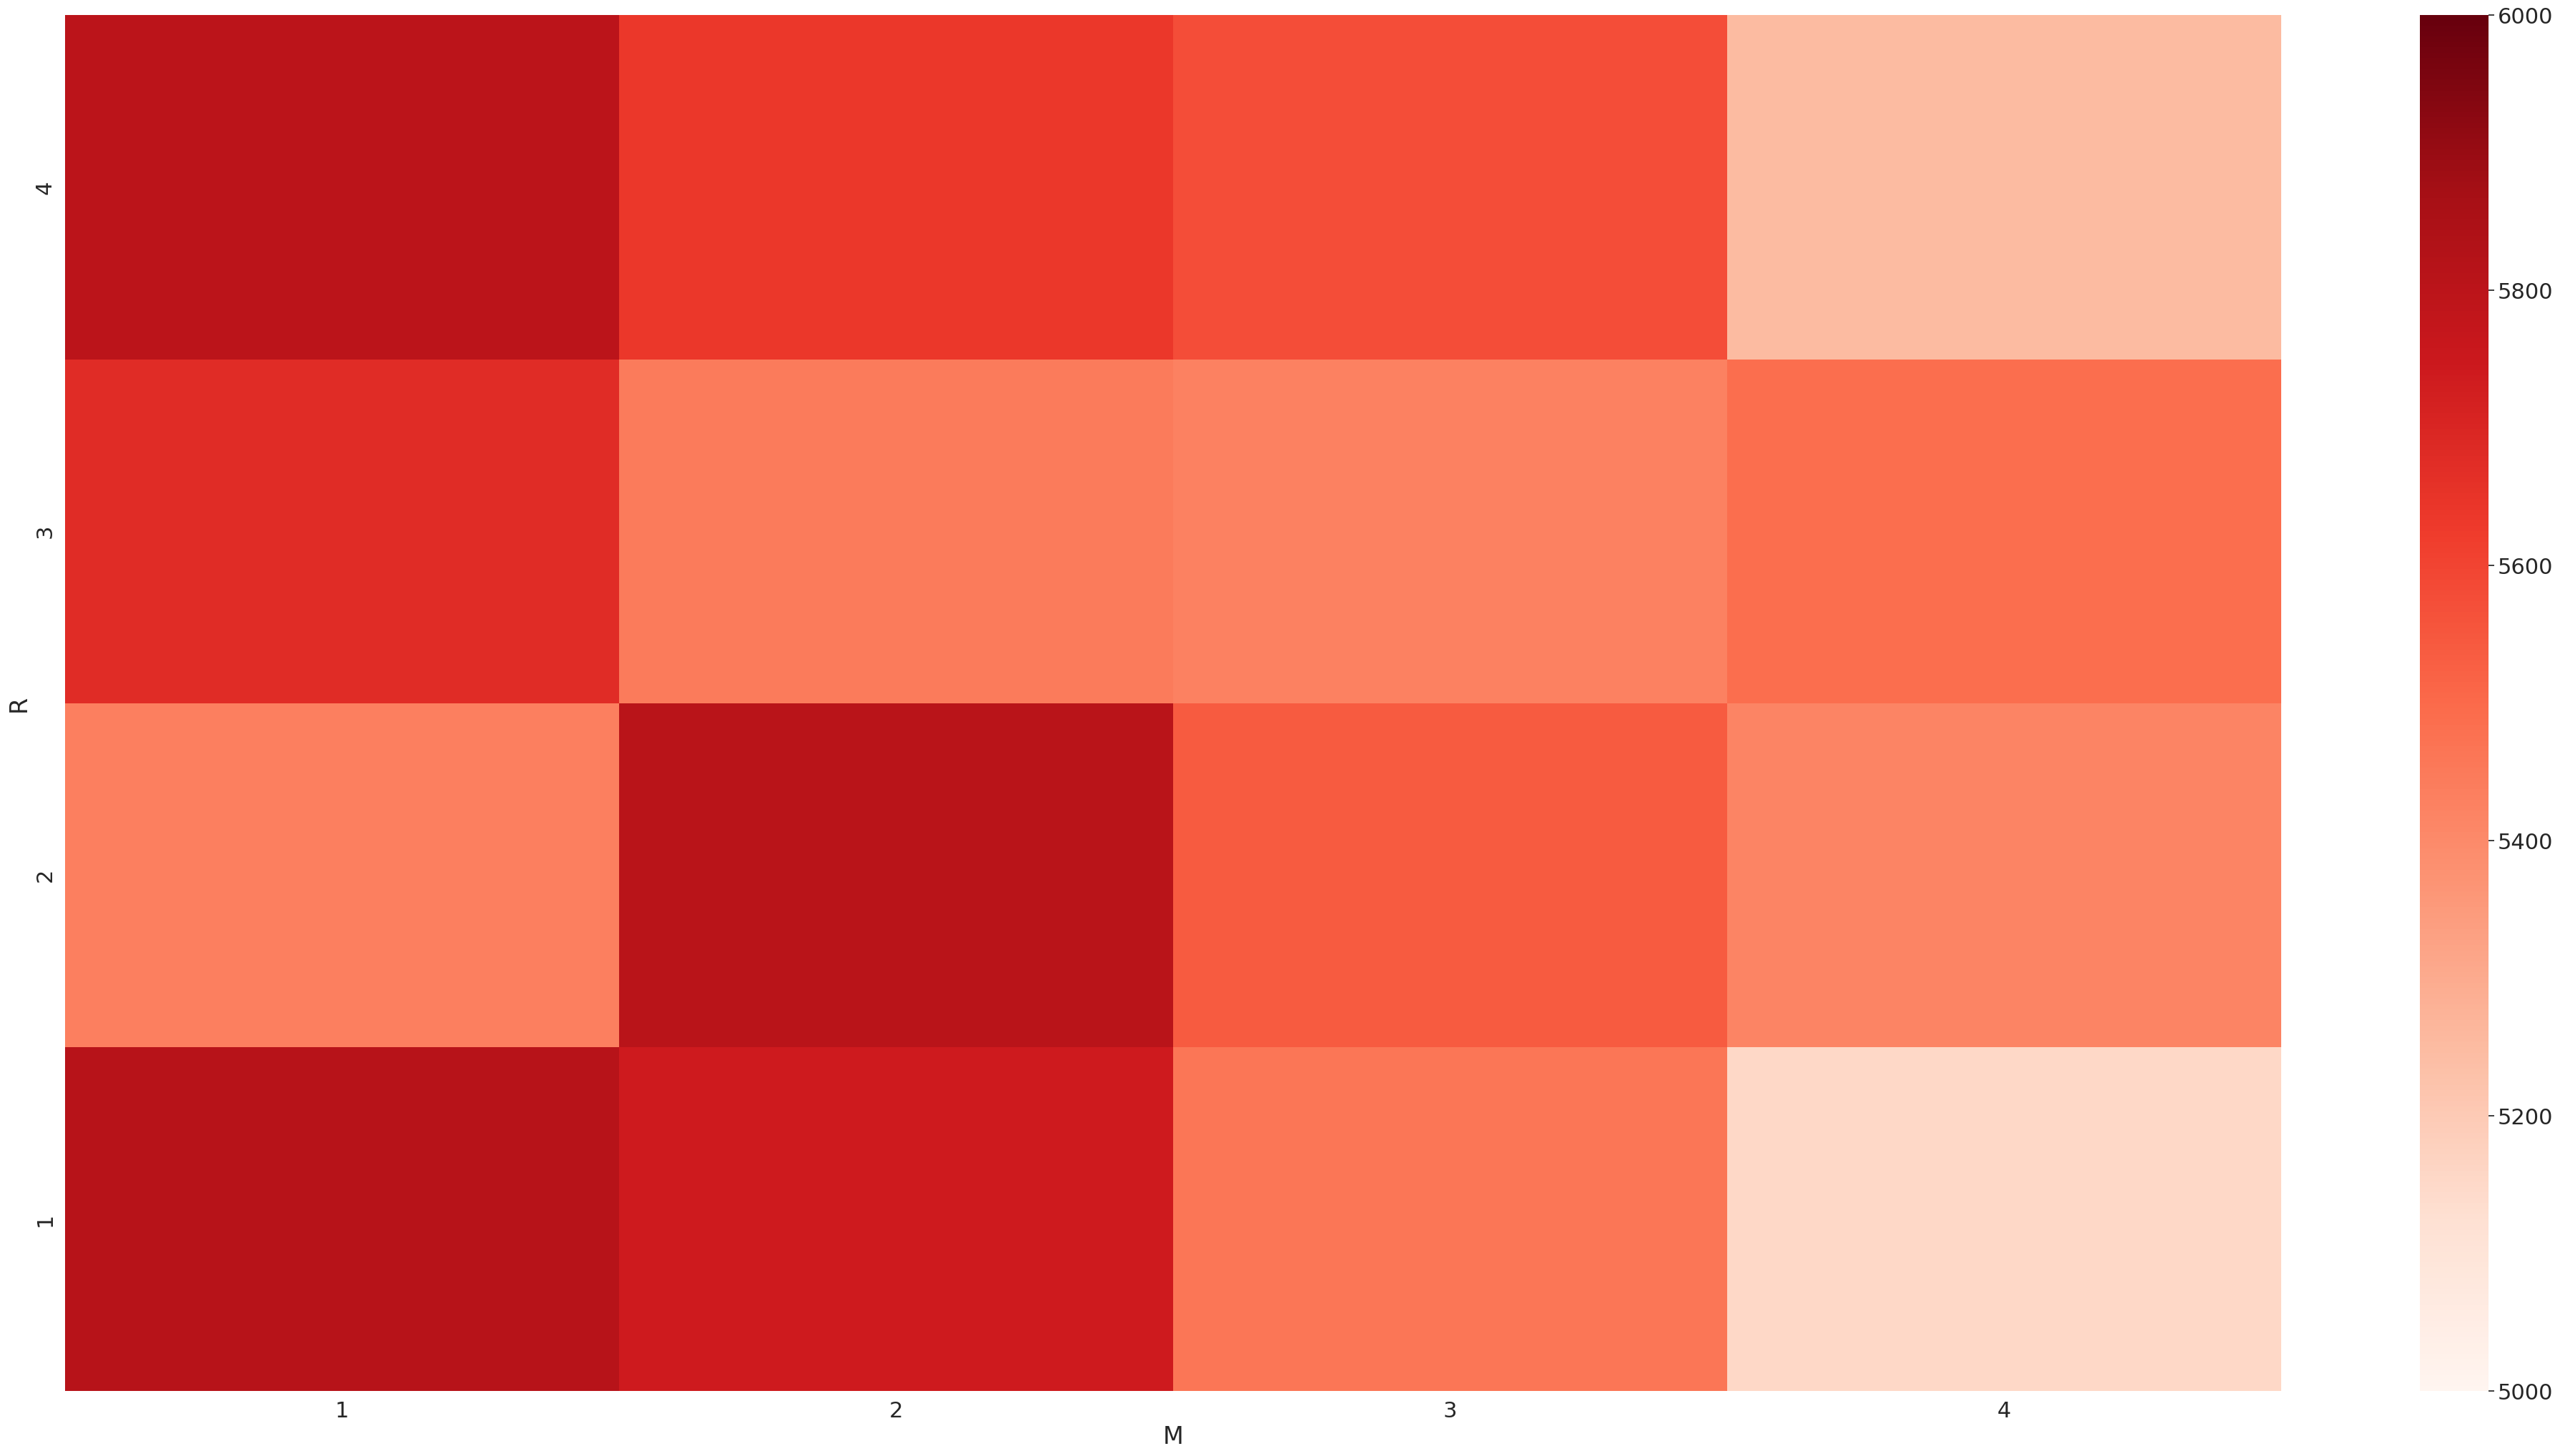

In [188]:
one_purchase_grid = sns.heatmap(
    data = clusters.query("F == 1").pivot(index='R', columns='M', values='users').reindex(index = [4,3,2,1]), cmap="Reds", vmin=5000, vmax=6000
)


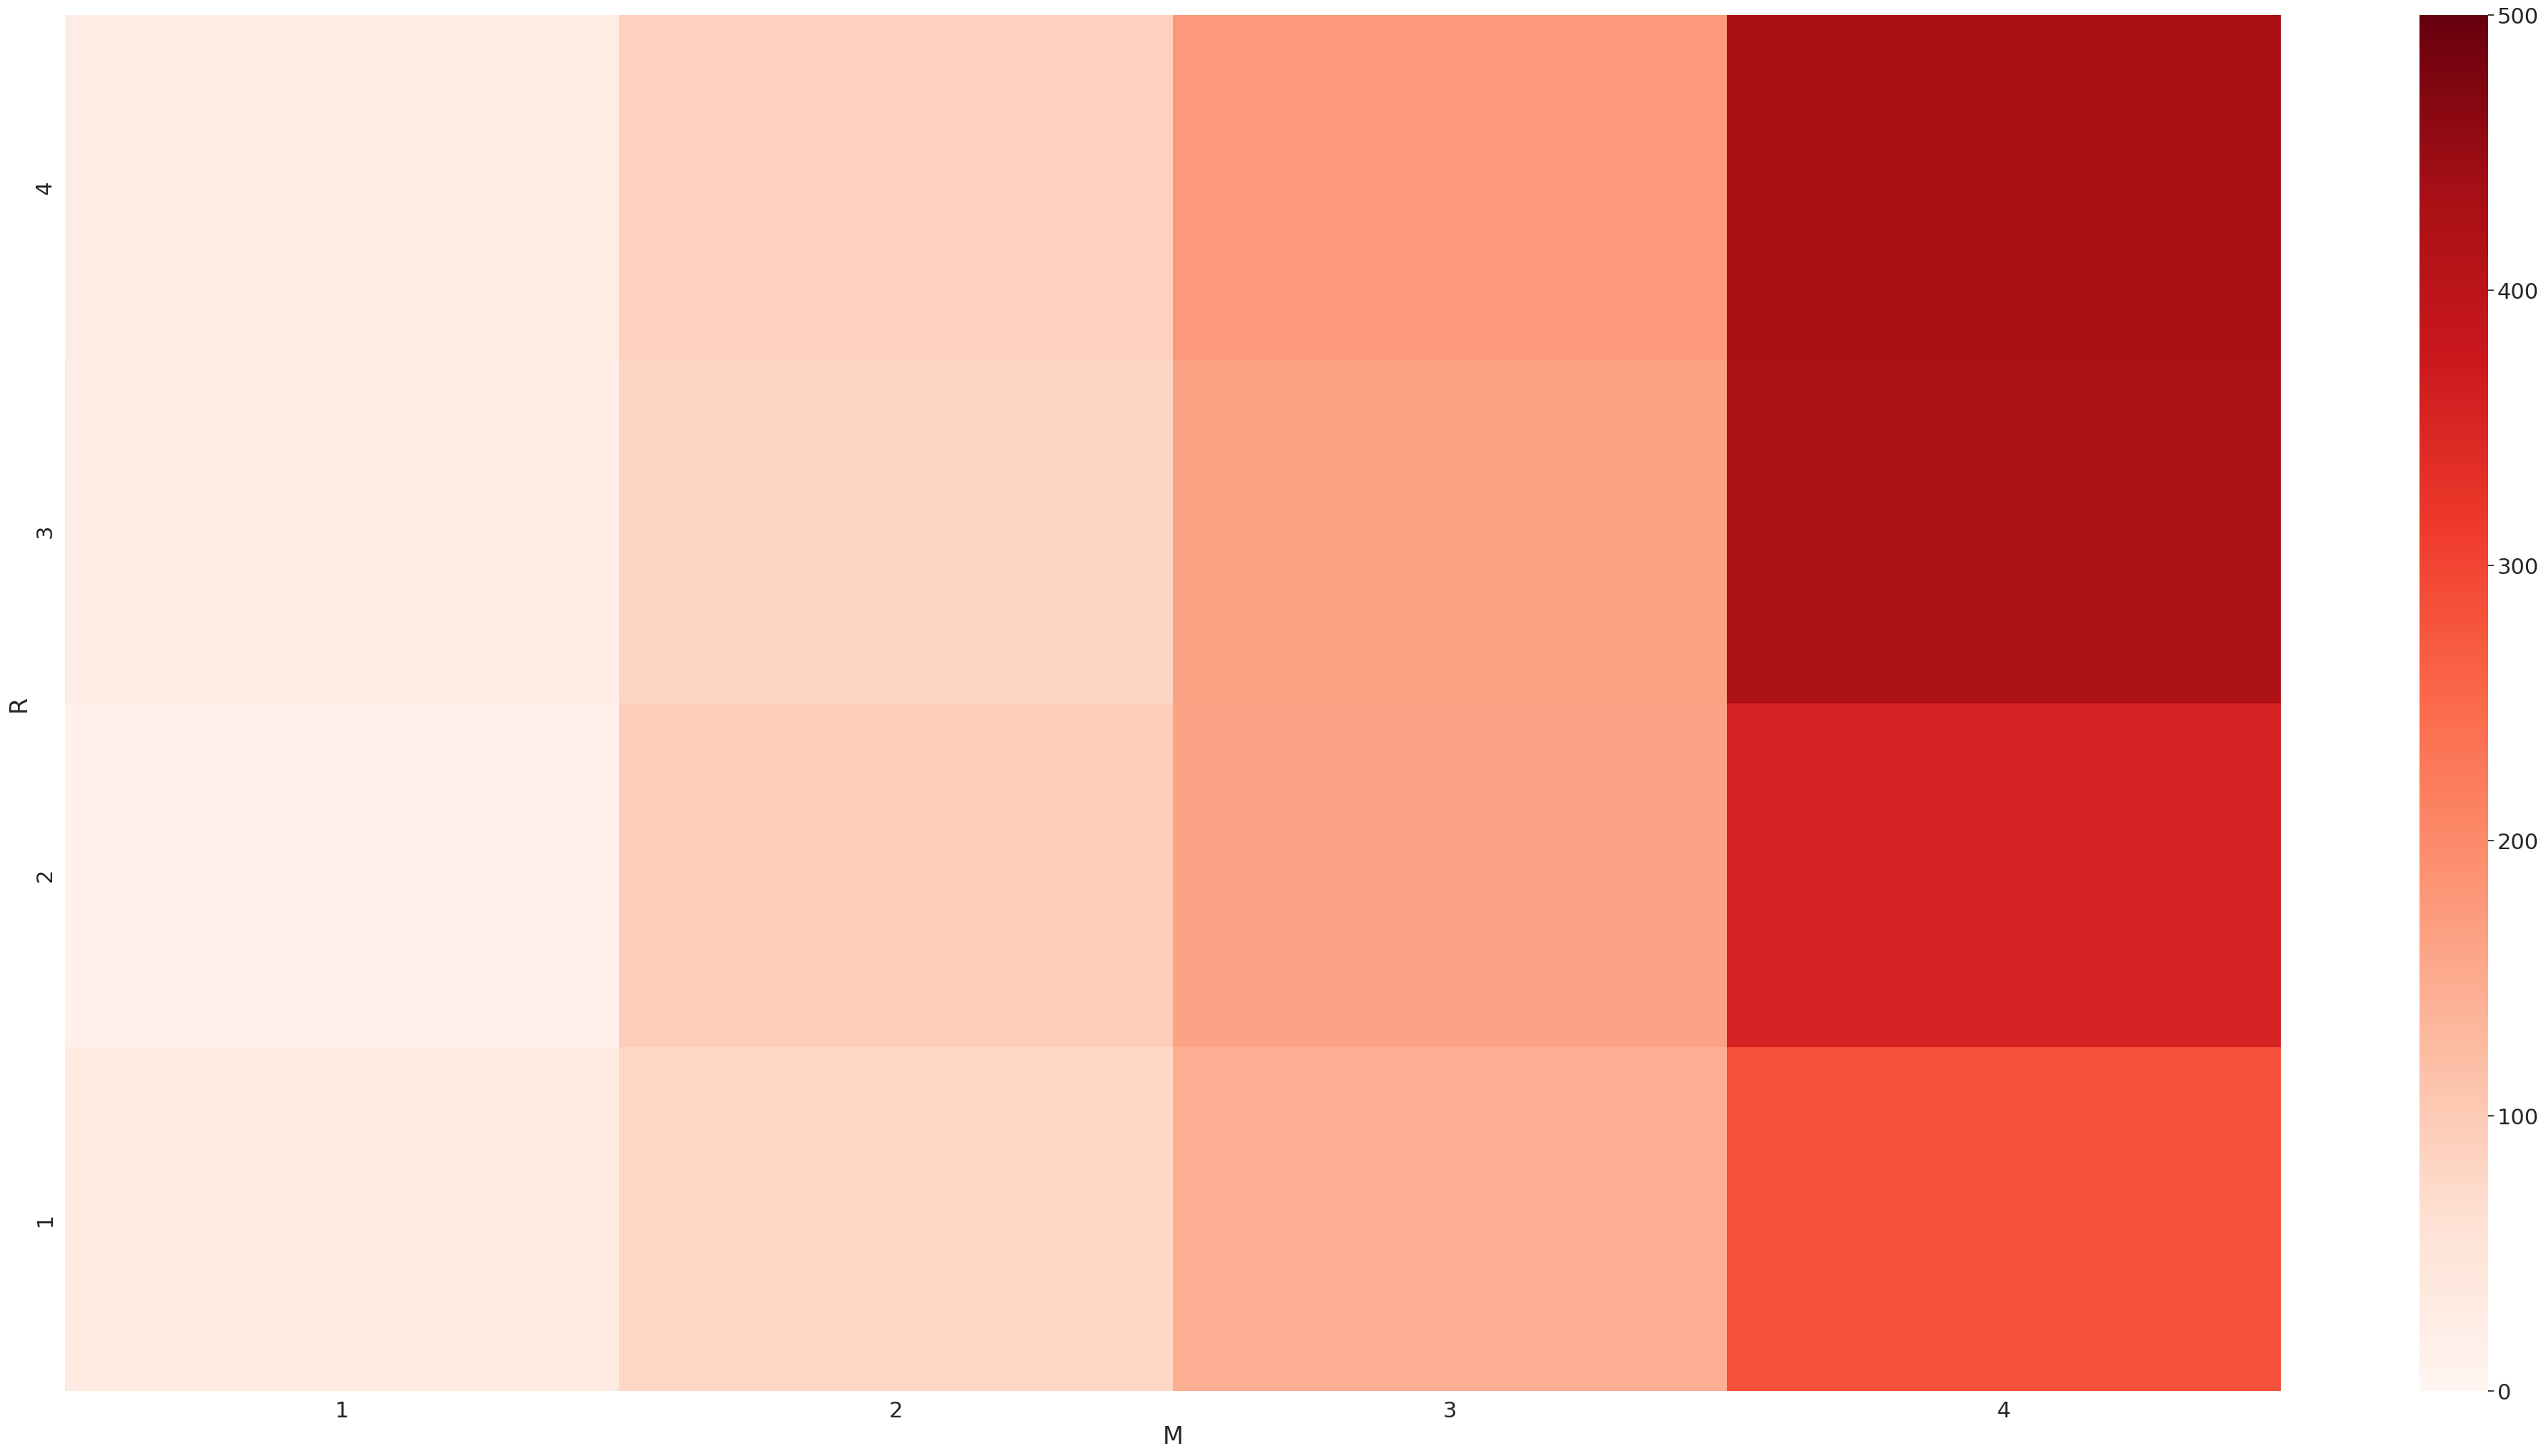

In [189]:
one_purchase_grid = sns.heatmap(
    data = clusters.query("F != 1").pivot(index='R', columns='M', values='users').reindex(index = [4,3,2,1]), cmap="Reds", vmin=0, vmax=500
)


Описание

Поскольку большая часть пользователей имеет всего одну покупку, то самое изначально стоит поделить группы по признаку F. Изучение показателей R и M групп с одной и многими покупками нам показывает,
что систиматичной разницы нет для группы с одной покупкой. Это логично так как при одной покупке не выработался еще патерн поведения клиента и сложно оценить их схожесть друг к другу. Для грппы с многими покупками
показатель M оказался важным - он создает более явные группы нежели R, который как будто не имеет эффекта. 

В связи с этим моя рекомендация создать три сегмента:
  - F = 1 - одноразовые пользователи которые еще имеют явного патерна - их лучше не трогать 
  - F = 2 and M <= 2 - пользователи которые попробовали предложения компании, но не нашли то что искали - стоит либо улучшить преложения, либо глубже изучить этот сегмент и понять что им не поравилось 
  - F = 2 and M >= 3 - пользователи которых можно считать "постоянными" - стоит изучить какие другие предложения могли бы заинтерисовать этот сегмент



In [180]:
segt_map = {
    r'1[1-4]': 'one time buyers',
    r'2[1-2]': 'lost customers',
    r'2[3-4]': 'regular customers'
}

rfm['Segment'] = rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

<AxesSubplot: xlabel='Segment', ylabel='users'>

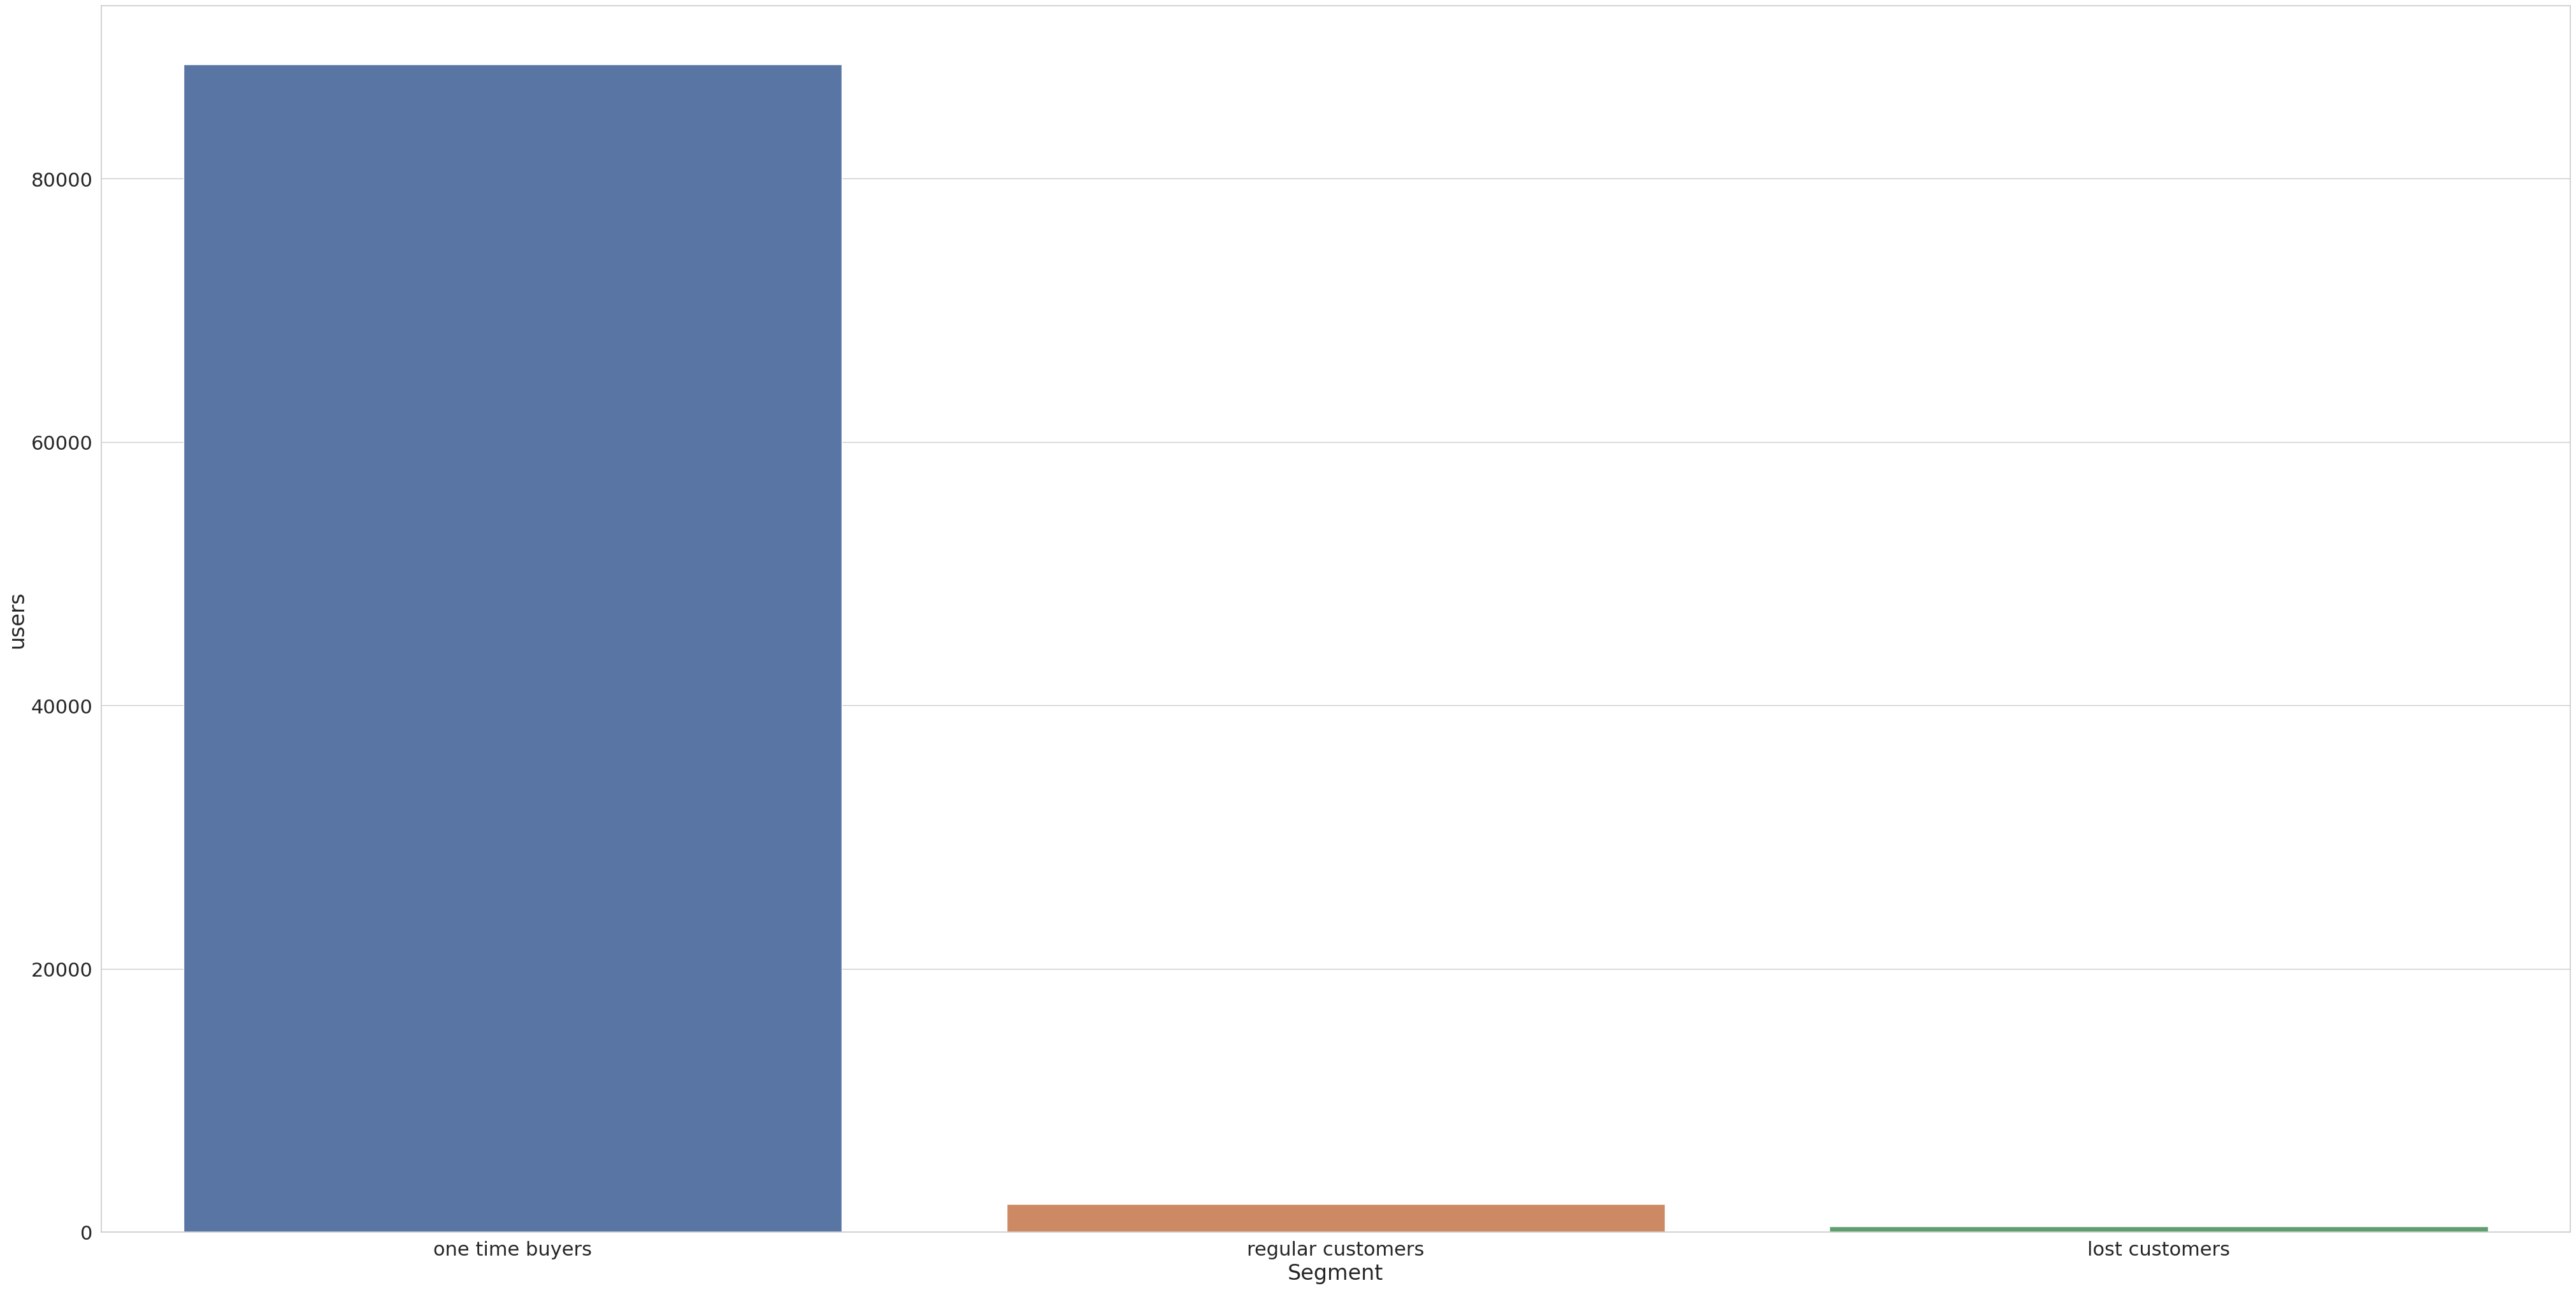

In [186]:
sns.barplot(
    data = (
        rfm
        .groupby('Segment', as_index=False)
        .agg(users=('customer_unique_id','nunique'))
    ),
    x = 'Segment',
    y = 'users',
    order = ['one time buyers', 'regular customers', 'lost customers']
)

In [ ]:
git branch andrey_bubenchshikov_07.10_a-bubenschikov-30/variant1

1st project, 07.10